In [1]:
import jax
import jax.numpy as jnp
import jax.random as rand

import gymnax
from gymnax.environments.environment import Environment
from gymnax.visualize import Visualizer
import wandb

import matplotlib.pyplot as plt
from IPython.display import Image

import equinox as eqx
import optax
import distrax

from typing import NamedTuple
from collections.abc import Callable
from jaxtyping import Bool, Integer, Float, Array
from functools import partial
import math

In [2]:
class Config(NamedTuple):
    eps_init: float
    eps_end: float
    eps_steps: int
    eps_begin: int

    lr_init: float
    lr_end: float

    buffer_size: int
    batch_size: int

    steps_per_update: int
    update_steps: int
    updates_per_target: int
    target_update_size: float

    discount: float


class Transition(NamedTuple):
    obs: Float[Array, "..."]
    env_state: gymnax.EnvState
    action: Integer[Array, ""]
    reward: Float[Array, ""]
    done: Bool[Array, ""]

    @property
    def size(self):
        return self.action.size

In [3]:
class _ObsAndGymnaxState(NamedTuple):
    obs: Float[Array, "..."]
    env_state: gymnax.EnvState


def collect_transitions(
    rng: rand.PRNGKey,
    params: eqx.Module,
    init_step: int,
    n: int,
    # static
    model_static: eqx.Module,
    env: gymnax.environments.environment.Environment,
    env_params: gymnax.EnvParams,
    epsilon_schedule: optax.Schedule,
):
    model = eqx.combine(params, model_static)

    def env_step(carry: _ObsAndGymnaxState, x: tuple[Integer[Array, ""], rand.PRNGKey]):
        step, rng = x
        rng_act, rng_step, rng_reset = rand.split(rng, 3)

        # choose action
        logits = model(carry.obs.ravel())
        action = distrax.EpsilonGreedy(logits, epsilon_schedule(init_step + step)).sample(
            seed=rng_act
        )

        # step environment
        next_obs, next_env_state, reward, done, info = env.step(
            rng_step, carry.env_state, action, env_params
        )

        next_obs, next_env_state = jax.lax.cond(
            done,
            lambda: env.reset(rng_reset, env_params),
            lambda: (next_obs, next_env_state),
        )

        return _ObsAndGymnaxState(
            obs=next_obs,
            env_state=next_env_state,
        ), Transition(
            obs=carry.obs,
            env_state=carry.env_state,
            action=action,
            reward=reward,
            done=done,
        )

    rng_reset, rng_step = rand.split(rng)
    obs, env_state = env.reset(rng_reset, env_params)
    _, transitions = jax.lax.scan(
        env_step,
        _ObsAndGymnaxState(obs, env_state),
        (
            jnp.arange(n),
            rand.split(rng_step, n),
        ),
    )
    return transitions

In [4]:
@partial(jax.vmap, in_axes=(None, None, 0, 0, None))
def loss_batch(params: eqx.Module, target_params: eqx.Module, txn: Transition, next_txn: Transition, model_static: eqx.Module):
    model = eqx.combine(params, model_static)
    target_model = eqx.combine(target_params, model_static)

    target = txn.reward + jax.lax.cond(
        txn.done,
        lambda: 0.0,
        lambda: config.discount * jnp.max(target_model(next_txn.obs.ravel())),
    )

    return (target - model(txn.obs.ravel())[txn.action]) ** 2


def loss_fn(
    params: eqx.Module,
    target_params: eqx.Module,
    txn: Transition,
    next_txn: Transition,
    model_static: eqx.Module,
):
    losses = loss_batch(params, target_params, txn, next_txn, model_static)
    return jnp.mean(losses)


class Buffer(NamedTuple):
    data: Transition
    count: Integer[Array, ""]

    @classmethod
    def init(cls, env: Environment, env_params: gymnax.EnvParams, size: int):
        obs, env_state = env.reset(rand.PRNGKey(0), env_params)
        txn = Transition(
            obs=jnp.zeros_like(obs),
            env_state=env_state,
            action=env.action_space(env_params).sample(rand.PRNGKey(0)),
            reward=jnp.zeros(()),
            done=jnp.array(False),
        )
        return Buffer(
            data=jax.tree.map(lambda leaf: jnp.broadcast_to(leaf, (size, *leaf.shape)), txn),
            count=0,
        )

    def add_batch(self, txns: Transition):
        idx = self.count + jnp.arange(txns.size) % self.data.size
        data = jax.tree.map(
            lambda batch, txns: batch.at[idx].set(txns),
            self.data,
            txns,
        )
        return Buffer(data, self.count + txns.size)

    def sample(self, rng, n) -> Transition:
        idxs = rand.randint(
            rng,
            (n,),
            1,
            jnp.minimum(self.count, self.data.size),
        )
        return jax.tree_map(
            lambda ary: ary[idxs - 1, ...],
            self.data,
        ), jax.tree_map(
            lambda ary: ary[idxs, ...],
            self.data,
        )

class _TrainCarry(NamedTuple):
    params: eqx.Module
    target_params: eqx.Module
    opt_state: optax.OptState
    buffer: Buffer


def train_step(
    carry: _TrainCarry,
    x: tuple[Integer[Array, ""], rand.PRNGKey],
    collect_transitions,
    optim: optax.GradientTransformation,
    model_static: eqx.Module,
):
    step, rng = x
    rng_collect, rng_buffer = rand.split(rng)

    # collect transitions
    n_txns = config.steps_per_update
    init_step = step * n_txns
    transitions = jax.vmap(collect_transitions, in_axes=(0, None, None, None))(rng_collect, carry.params, init_step, n_txns)
    buffer = carry.buffer.add_batch(transitions)

    loss, grads = jax.value_and_grad(loss_fn)(
        carry.params, carry.target_params, *buffer.sample(rng_buffer, config.batch_size), model_static
    )
    updates, opt_state = optim.update(grads, carry.opt_state, carry.params)
    params = eqx.apply_updates(carry.params, updates)

    target_params = jax.lax.cond(
        step % config.updates_per_target == 0,
        lambda: optax.incremental_update(
            carry.params,
            carry.target_params,
            config.target_update_size,
        ),
        lambda: carry.target_params,
    )

    jax.debug.callback(
        wandb.log,
        {
            "train/total_reward": jnp.sum(transitions.reward),
            "train/loss": loss,
        } | {
            f"train/gradient{jax.tree_util.keystr(keys)}": jnp.linalg.norm(update)
            for keys, update in jax.tree.leaves_with_path(updates)
            if update is not None
        }
    )

    return _TrainCarry(params, target_params, opt_state, buffer), loss


@jax.jit
def train(rng):
    rng_model, rng_steps = rand.split(rng)

    env, env_params = gymnax.make(config.env_name)

    params, model_static = get_model(rng_model, env, env_params)

    # optimization
    optim = optax.adamw(
        optax.linear_schedule(config.lr_init, config.lr_end, config.update_steps)
    )
    opt_state = optim.init(params)

    # transition collection
    epsilon_schedule = optax.linear_schedule(
        config.eps_init, config.eps_end, config.eps_steps, config.eps_begin
    )

    collect_transitions_ = partial(
        collect_transitions,
        model_static=model_static,
        env=env,
        env_params=env_params,
        epsilon_schedule=epsilon_schedule,
    )

    # training loop
    train_step_ = partial(train_step, collect_transitions=collect_transitions_, optim=optim, model_static=model_static)
    init_carry = _TrainCarry(params, params, opt_state, Buffer.init(env, env_params, config.buffer_size))
    carry, losses = jax.lax.scan(
        train_step_,
        init_carry,
        (jnp.arange(config.update_steps), rand.split(rng_steps, config.update_steps)),
    )
    return carry, losses

def get_model(rng: rand.PRNGKey, env: Environment, env_params: gymnax.EnvParams):
    """Initialize model"""
    # model initialization
    model = eqx.nn.MLP(
        in_size=math.prod(env.observation_space(env_params).shape),
        out_size=env.action_space(env_params).n,
        width_size=128,
        depth=2,
        key=rng,
    )
    params, model_static = eqx.partition(model, eqx.is_inexact_array)
    return params, model_static

In [5]:
rng = rand.PRNGKey(0)

In [6]:
rng, rng_train, rng_model = rand.split(rng, 3)

config = Config(
    env_name="Catch-bsuite",
    eps_init=1.0,
    eps_end=0.01,
    eps_steps=20_000,
    eps_begin=500,
    lr_init=0.01,
    lr_end=0.0001,
    buffer_size=1000,
    batch_size=400,
    steps_per_update=200,
    update_steps=5_000,
    updates_per_target=20,
    target_update_size=0.9,
    discount=0.99,
)

wandb.init(
    project="jax-rl",
    config=config._asdict(),
)

carry, losses = jax.block_until_ready(train(rng_train))

wandb: Currently logged in as: acaipie. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/Users/adzcai/Developer/muzero/.venv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [9]:
def visualize(rng, model: eqx.Module, n: int):
    rng_model, rng_reset, rng_collect = rand.split(rng, 3)
    env, env_params = gymnax.make("Catch-bsuite")

    _, model_static = get_model(rng_model, env, env_params)

    obs, env_state = env.reset(rng_reset, env_params)
    transitions = jax.jit(collect_transitions, static_argnames=("model_static", "init_step", "n", "env", "env_params", "epsilon_schedule"))(
        rng_collect,
        model,
        0,
        n,
        env=env,
        env_params=env_params,
        model_static=model_static,
        epsilon_schedule=optax.constant_schedule(0.0),
    )
    env_states = jax.tree.transpose(
        jax.tree.structure(env_state),
        None,
        jax.tree.map(lambda leaf: list(leaf), transitions.env_state),
    )
    vis = Visualizer(env, env_params, env_states, jnp.cumsum(transitions.reward))
    vis.animate("./anim.gif")
    plt.close()
    return Image("./anim.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


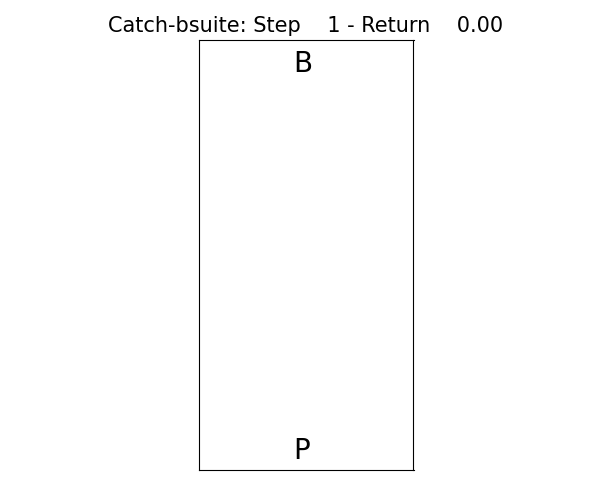

In [8]:
visualize(rand.PRNGKey(2), carry.params, 1000)